In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Simulating price impacts of different order sizes

This notebook contains simlations of how different order sizes impact premium price in pools of different size. 

## Table of Contents:
* [Deploying contracts](#Deploying-contracts)
* [Generating data](#Generating-data)
* [Plot summary](#Plot-summary)
* [Table summary](#Table-summary)
* [Verbose summary](#Verbose-summary)

There were some changes done to the AMM itself, which won't be included in the commit, but can be easily reproducible:

 - hardcoded ETH price of 1.2k
     - changed value of underlying_price in amm.cairo
 - changed init_pool function in initialize_amm.cairo
     - changed name to init_pool_dummy and it now takes an initial pool size number as an input
 -  hardcoded current block time in _time_till_maturity
     - changed curr_time in amm.cairo to 1640991600 -> 31/12/2021 

In [3]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from starkware.starknet.testing.starknet import Starknet
from starkware.starknet.testing.contract import StarknetContract
from starkware.starkware_utils.error_handling import StarkException

from aux import (
    USER_ID,
    STARTING_TOKEN_BALANCE_1,
    STARTING_TOKEN_BALANCE_2,
    STRIKE_PRICE,
    CURRENT_PRICE,
    CURRENT_PRICE_2,
    do_trade,
    show_current_premium,
    MATURITY,
    show_pool_volatility
)


### Deploying contracts

In [2]:
net = await Starknet.empty()

In [3]:
async def deploy_and_add_tokens(pool_size):
    mm = await net.deploy(source = os.path.join('..', '..', 'contracts/main.cairo'), 
    cairo_path = ['../..', 
                 '../../lib/cairo_math_64x61/contracts/cairo_math_64x61',
                 '../../contracts'])
    await mm.init_pool_dummy(pool_size).invoke()

    await mm.add_fake_tokens(
        account_id=USER_ID,
        amount_token_a=STARTING_TOKEN_BALANCE_1,
        amount_token_b=STARTING_TOKEN_BALANCE_2).invoke()
    return mm

In [21]:
# Define pool and order sizes to test

pool_sizes = [10_000, 20_000, 35_000 ,75_000]

# Define weights of trades -> proportion of the pool that is to be traded
weights = [0.0025, 0.005, 0.0075, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.9]

In [34]:
# Deploy contracts and store them in dict for easier iteration

data = {
    pool_size : {
        'func': await deploy_and_add_tokens(pool_size)
    } for pool_size in pool_sizes
}

### Generating data

In [36]:
for key in data.keys():
    data[key]['records'] = []
    print(f'Working on amm with pool size: {key:_}')
    
    order_sizes = [weight*key for weight in weights]
    for order_size in order_sizes:
        try: 
            tmp = {}
            tmp['order_size'] = order_size
            print(f'  Current order size: {order_size:_}')

            # Retrieve premium and volatility before trades
            tmp.update({f'init_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1 * 2**61, True)).items()})
            tmp.update({f'init_{k}': value for k, value in (await show_pool_volatility(data[key]['func'], True)).items()})

            # Conduct trades
            await do_trade(data[key]['func'], int(order_size * 2**61), 0, 0)
            await do_trade(data[key]['func'], int(CURRENT_PRICE_2 *order_size * 2**61), 1, 0)

            # Retrieve premium and volatility after trades
            tmp.update({f'after_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1 * 2**61, True)).items()})
            tmp.update({f'after_{k}': value for k, value in (await show_pool_volatility(data[key]['func'], True)).items()})

            # Calculate changes in premium
            tmp['premium_change_CALL'] = tmp['after_prem_CALL'] - tmp['init_prem_CALL']
            tmp['premium_change_PUT'] = tmp['after_prem_PUT'] - tmp['init_prem_PUT']

            tmp['perc_premium_change_CALL'] =  (tmp['after_prem_CALL'] / tmp['init_prem_CALL'] - 1) * 100
            tmp['perc_premium_change_PUT'] = (tmp['after_prem_PUT'] / tmp['init_prem_PUT'] - 1) * 100

            tmp['volatility_change_CALL'] = tmp['after_pool_vol_CALL'] - tmp['init_pool_vol_CALL']
            tmp['volatility_change_PUT'] = tmp['after_pool_vol_PUT'] - tmp['init_pool_vol_PUT']

            tmp['perc_volatility_change_CALL'] = (tmp['after_pool_vol_CALL'] / tmp['init_pool_vol_CALL'] - 1) * 100
            tmp['perc_volatility_change_PUT'] = (tmp['after_pool_vol_PUT'] / tmp['init_pool_vol_PUT'] - 1 ) * 100

            data[key]['records'].append(tmp)

            # Reset the pools for the next order size simulation
            data[key]['func'] = await deploy_and_add_tokens(key)

        except StarkException:
            print(f"  ERROR at order_size: {order_size:_}")
            continue

Working on amm with pool size: 10_000
  Current order size: 25.0
  Current order size: 50.0
  Current order size: 75.0
  Current order size: 100.0
  Current order size: 500.0
  Current order size: 750.0
  Current order size: 1_000.0
  Current order size: 2_500.0
  Current order size: 5_000.0
  Current order size: 9_000.0
Working on amm with pool size: 20_000
  Current order size: 50.0
  Current order size: 100.0
  Current order size: 150.0
  Current order size: 200.0
  Current order size: 1_000.0
  Current order size: 1_500.0
  Current order size: 2_000.0
  Current order size: 5_000.0
  Current order size: 10_000.0
  Current order size: 18_000.0
Working on amm with pool size: 35_000
  Current order size: 87.5
  Current order size: 175.0
  Current order size: 262.5
  Current order size: 350.0
  Current order size: 1_750.0
  Current order size: 2_625.0
  Current order size: 3_500.0
  Current order size: 8_750.0
  Current order size: 17_500.0
  Current order size: 31_500.0
Working on amm 

**Errors indicate places where there wasnt enough funds in the pool.**

In [38]:
# Remove Starknet Contracts from data because it's not serializable for pickle

for key in data.keys():
    del data[key]['func']

In [137]:
# Generating data can take quite a while, so it's provided in a pickle file
# with open('data_current_1200.pickle', 'wb') as f:
#     pickle.dump(data, f)

# with open('data_current_1200.pickle', 'rb') as f:
#     data = pickle.load(f)

<!-- Little easter egg :) -->

### Plot summary

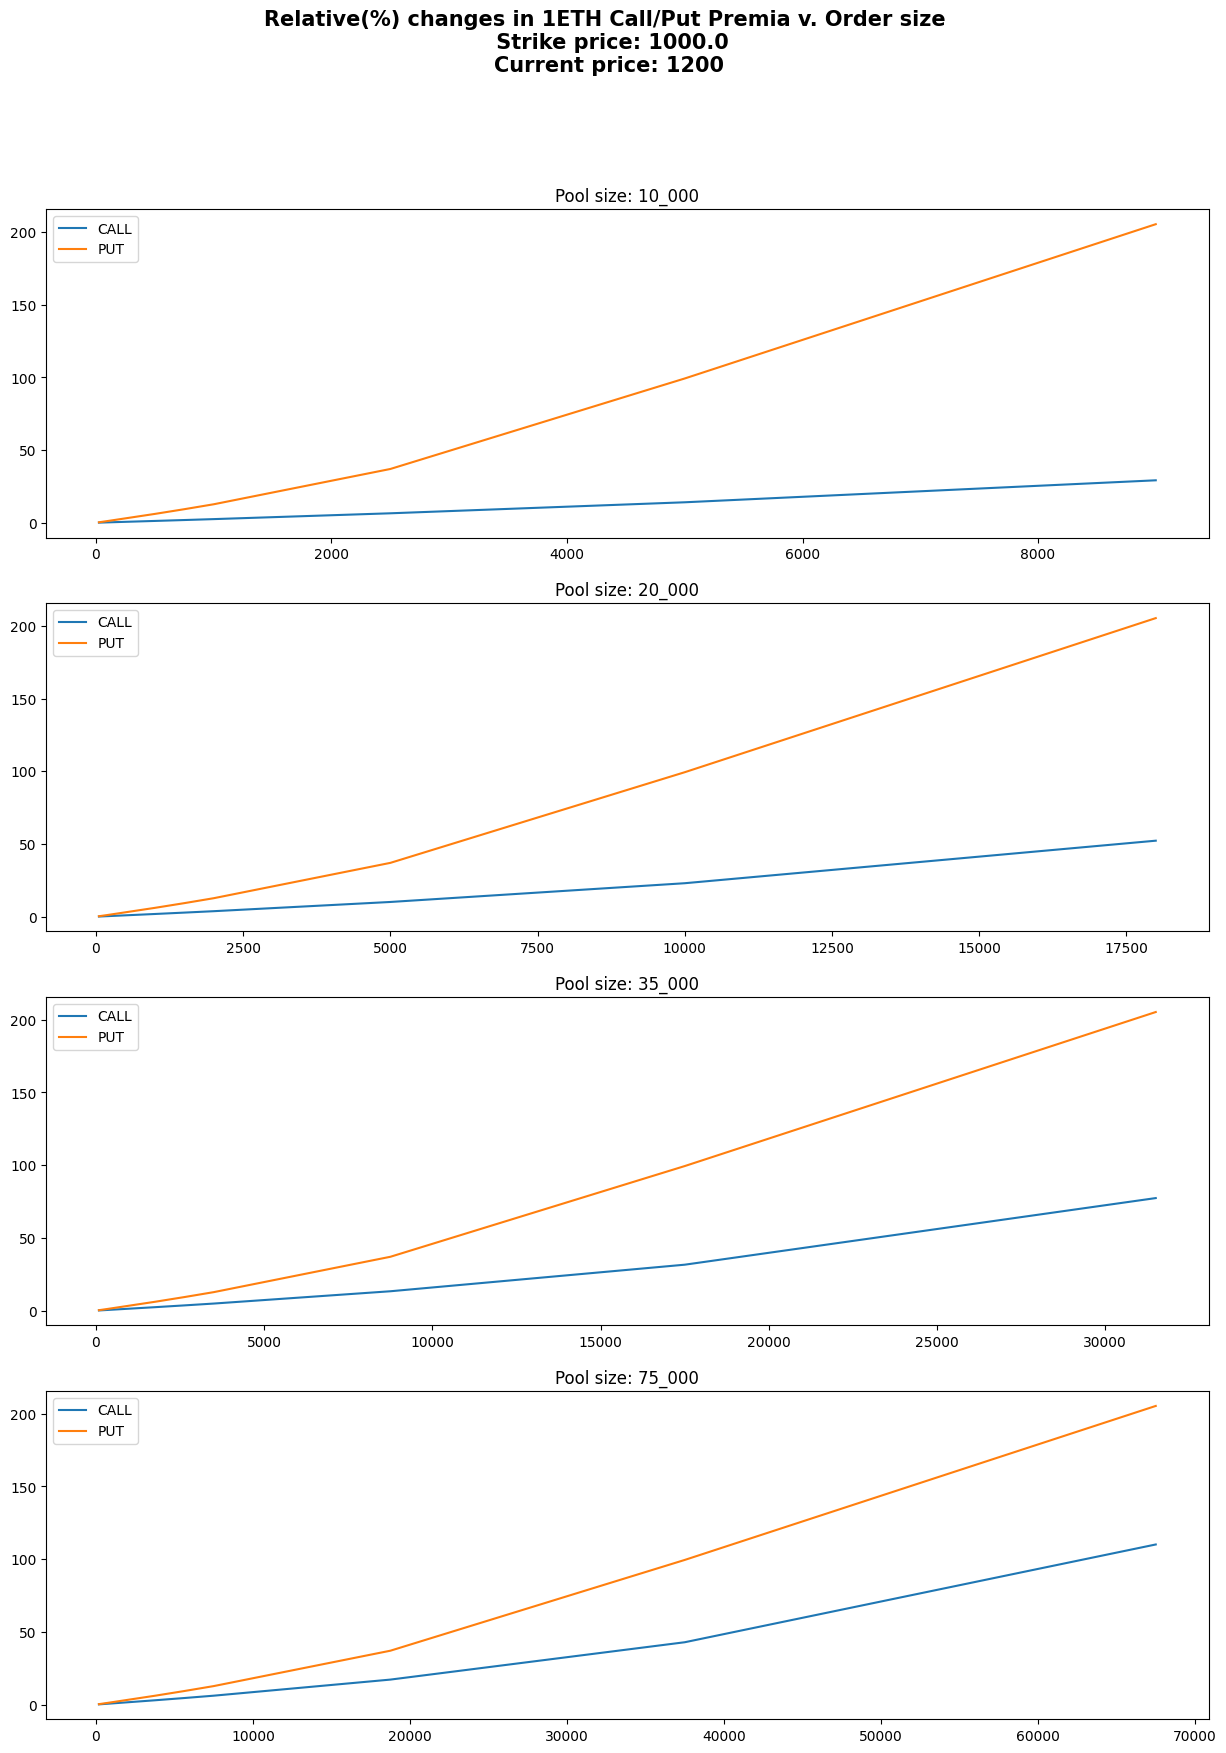

In [6]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: {CURRENT_PRICE}", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')

Whole process is repeated, but now with hardcoded ETH price of $800.

In [17]:
# File containing data for sims with current price = 800 named data_current_800.pickle

# with open('data_current_800.pickle', 'rb') as f:
#     data_2 = pickle.load(f)

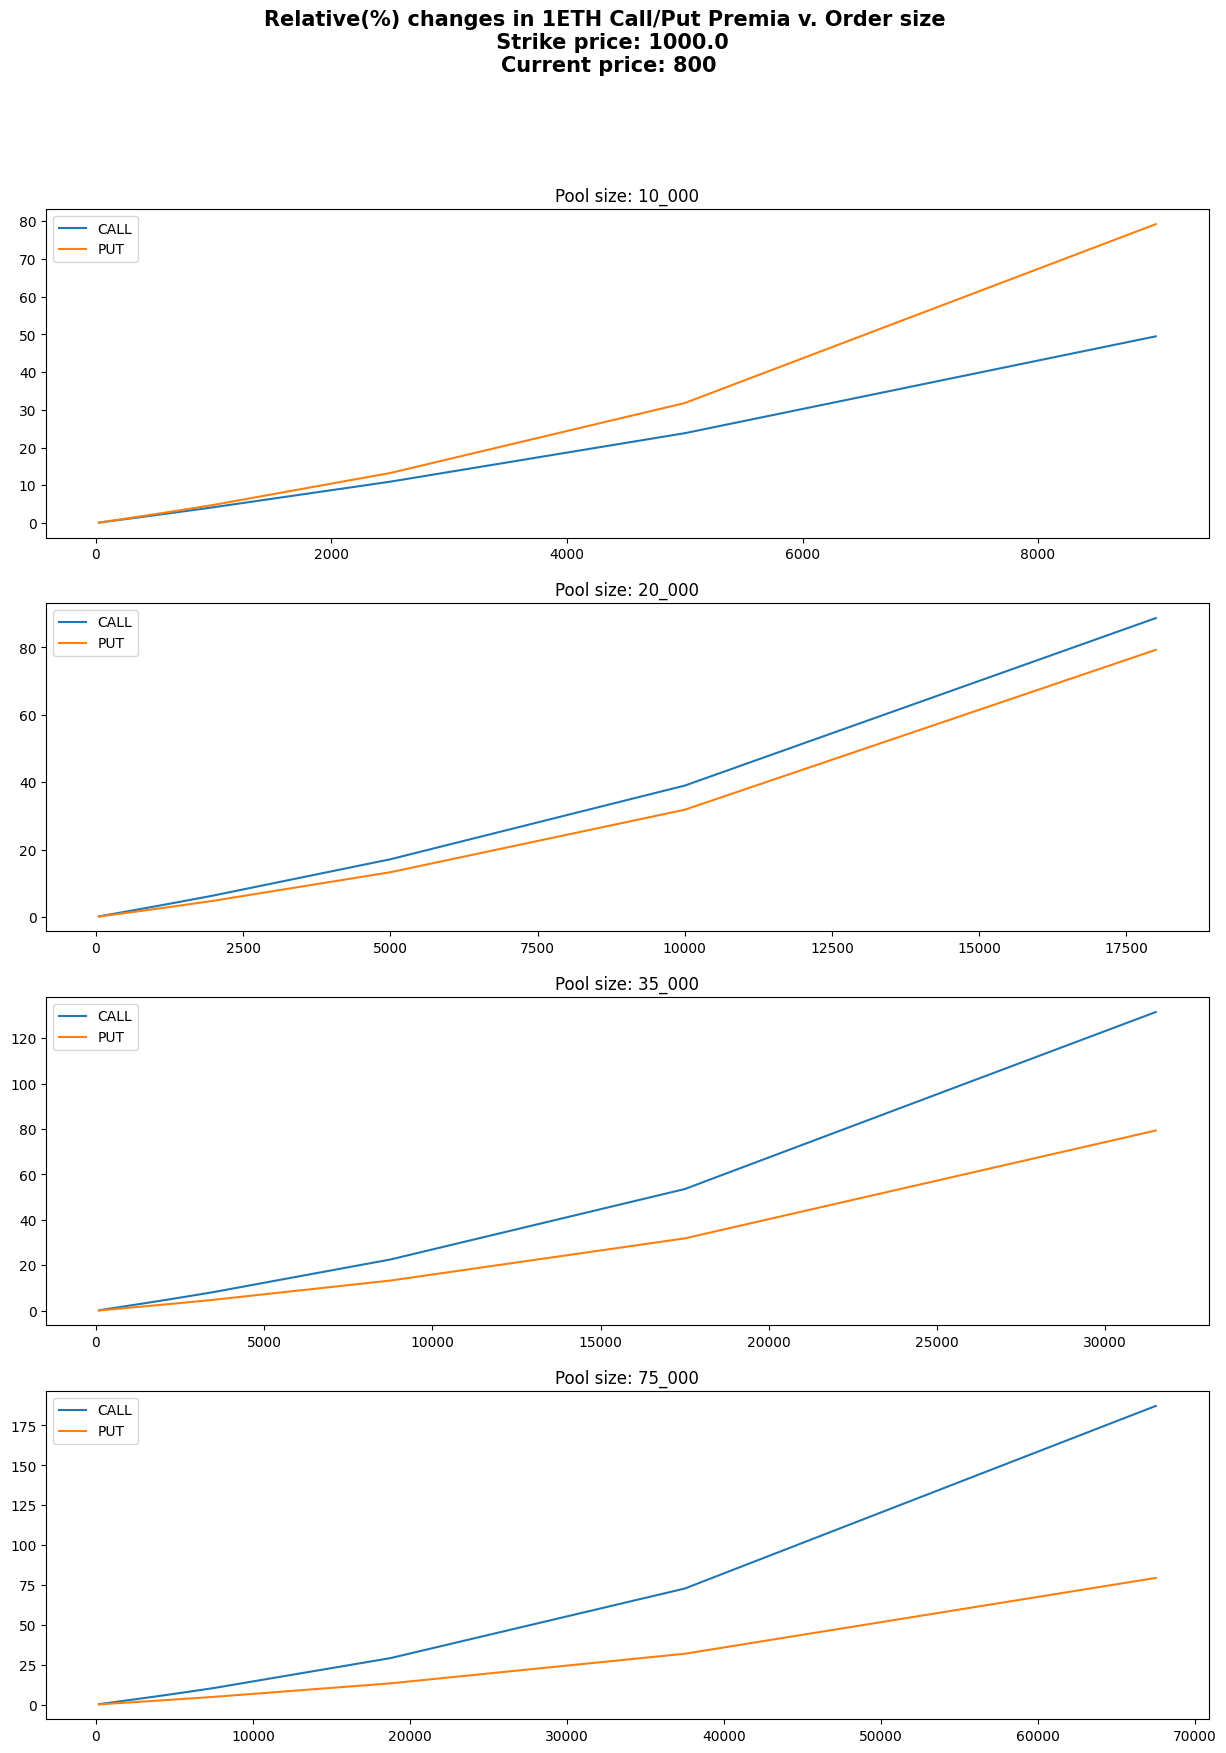

In [42]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data_2.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: {CURRENT_PRICE_2}", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data_2.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')

### Table summary

In [22]:
weights

[0.0025, 0.005, 0.0075, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.9]

In [86]:
colnames = ['Order size as percentage of pool']
df_1 = []
df_1.append([str(i * 100) + '%' for i in weights])
for key, value in data.items():
    tmp = [str(round(i['perc_premium_change_CALL'], 4)) + '%' for i in value['records']]
    tmp2 = [str(round(i['perc_premium_change_PUT'], 4)) + '%' for i in value['records']]
    colnames.append(f"{key}_CALL")
    colnames.append(f"{key}_PUT")
    df_1.append(tmp)
    df_1.append(tmp2)
    
df_1 = pd.concat([pd.Series(i) for i in df_1], axis=1)
df_1 = df_1.rename(columns = {i: colnames[i] for i in df_1.columns})

df_2= []
df_2.append([str(i * 100) + '%' for i in weights])
for key, value in data_2.items():
    tmp = [str(round(i['perc_premium_change_CALL'], 4)) + '%' for i in value['records']]
    tmp2 = [str(round(i['perc_premium_change_PUT'], 4)) + '%' for i in value['records']]
    df_2.append(tmp)
    df_2.append(tmp2)

df_2 = pd.concat([pd.Series(i) for i in df_2], axis=1)
df_2 = df_2.rename(columns = {i: colnames[i] for i in df_2.columns})


In [90]:
print(f'Strike price: 1000, Current price: 1200')
df_1.set_index(r'Order size as percentage of pool')

Strike price: 1000, Current price: 1200


,10000_CALL,10000_PUT,20000_CALL,20000_PUT,35000_CALL,35000_PUT,75000_CALL,75000_PUT
Order size as percentage of pool,,,,,,,,
0.25%,0.06%,0.2897%,0.09%,0.2899%,0.1145%,0.29%,0.1422%,0.2901%
0.5%,0.12%,0.5806%,0.1801%,0.5811%,0.2294%,0.5813%,0.2848%,0.5814%
0.75%,0.1801%,0.8728%,0.2705%,0.8736%,0.3446%,0.8739%,0.428%,0.8741%
1.0%,0.2404%,1.1664%,0.3611%,1.1674%,0.4601%,1.1678%,0.5716%,1.1681%
5.0%,1.2164%,6.0486%,1.8384%,6.0538%,2.3544%,6.0561%,2.9414%,6.0577%
7.5%,1.8384%,9.2873%,2.7893%,9.2956%,3.5836%,9.2991%,4.4935%,9.3016%
10.0%,2.4699%,12.6815%,3.7622%,12.6931%,4.8494%,12.6981%,6.1036%,12.7016%
25.0%,6.4697%,36.9515%,10.1035%,36.9906%,13.3032%,37.0073%,17.1644%,37.0193%
50.0%,14.0441%,99.1858%,22.9921%,99.3197%,31.5696%,99.3772%,42.8401%,99.4181%


In [91]:
print(f'Strike price: 1000, Current price: 800')
df_2.set_index(r'Order size as percentage of pool')

Strike price: 1000, Current price: 800


,10000_CALL,10000_PUT,20000_CALL,20000_PUT,35000_CALL,35000_PUT,75000_CALL,75000_PUT
Order size as percentage of pool,,,,,,,,
0.25%,0.1015%,0.1131%,0.1523%,0.1132%,0.1939%,0.1133%,0.2406%,0.1133%
0.5%,0.2031%,0.2266%,0.3049%,0.2268%,0.3883%,0.2269%,0.482%,0.2269%
0.75%,0.3049%,0.3404%,0.4578%,0.3407%,0.5832%,0.3408%,0.7243%,0.3409%
1.0%,0.4068%,0.4546%,0.6111%,0.4549%,0.7788%,0.4551%,0.9675%,0.4552%
5.0%,2.0588%,2.3287%,3.1118%,2.3307%,3.9854%,2.3316%,4.9793%,2.3322%
7.5%,3.1118%,3.5475%,4.7217%,3.5506%,6.0669%,3.5519%,7.608%,3.5529%
10.0%,4.181%,4.8047%,6.3693%,4.8089%,8.2109%,4.8107%,10.3358%,4.812%
25.0%,10.9559%,13.2522%,17.1152%,13.2652%,22.5415%,13.2707%,29.0931%,13.2746%
50.0%,23.7983%,31.7865%,38.9871%,31.8232%,53.5609%,31.8389%,72.7265%,31.8501%


### Verbose summary

In [134]:
def print_info(data, strike, current):
    for key, item in data.items():
        print(f"For strike price {strike}, current price {current}, pool size {key:_} ETH")
        for trade in item['records']:
            print(f"   Call premium shifts by {trade['perc_premium_change_CALL']:.4f}% when we trade option of size {trade['order_size']} ETH ({trade['order_size'] / key:.2%} of the pool)")
            print(f"   Put premium shifts by {trade['perc_premium_change_PUT']:.4f}% when we trade option of size {trade['order_size']} ETH ({trade['order_size'] / key:.2%} of the pool)")
     

In [135]:
print_info(data, 1200, 1000)

For strike price 1200, current price 1000, pool size 10_000 ETH
   Call premium shifts by 0.0600% when we trade option of size 25.0 ETH (0.25% of the pool)
   Put premium shifts by 0.2897% when we trade option of size 25.0 ETH (0.25% of the pool)
   Call premium shifts by 0.1200% when we trade option of size 50.0 ETH (0.50% of the pool)
   Put premium shifts by 0.5806% when we trade option of size 50.0 ETH (0.50% of the pool)
   Call premium shifts by 0.1801% when we trade option of size 75.0 ETH (0.75% of the pool)
   Put premium shifts by 0.8728% when we trade option of size 75.0 ETH (0.75% of the pool)
   Call premium shifts by 0.2404% when we trade option of size 100.0 ETH (1.00% of the pool)
   Put premium shifts by 1.1664% when we trade option of size 100.0 ETH (1.00% of the pool)
   Call premium shifts by 1.2164% when we trade option of size 500.0 ETH (5.00% of the pool)
   Put premium shifts by 6.0486% when we trade option of size 500.0 ETH (5.00% of the pool)
   Call premium s

In [136]:
print_info(data_2, 800, 1000)

For strike price 800, current price 1000, pool size 10_000 ETH
   Call premium shifts by 0.1015% when we trade option of size 25.0 ETH (0.25% of the pool)
   Put premium shifts by 0.1131% when we trade option of size 25.0 ETH (0.25% of the pool)
   Call premium shifts by 0.2031% when we trade option of size 50.0 ETH (0.50% of the pool)
   Put premium shifts by 0.2266% when we trade option of size 50.0 ETH (0.50% of the pool)
   Call premium shifts by 0.3049% when we trade option of size 75.0 ETH (0.75% of the pool)
   Put premium shifts by 0.3404% when we trade option of size 75.0 ETH (0.75% of the pool)
   Call premium shifts by 0.4068% when we trade option of size 100.0 ETH (1.00% of the pool)
   Put premium shifts by 0.4546% when we trade option of size 100.0 ETH (1.00% of the pool)
   Call premium shifts by 2.0588% when we trade option of size 500.0 ETH (5.00% of the pool)
   Put premium shifts by 2.3287% when we trade option of size 500.0 ETH (5.00% of the pool)
   Call premium sh